MIT license notice
© 2024 Saurabh Pathak. All rights reserved
Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated
documentation files (the "Software"), to deal in the Software without restriction, including without limitation the
rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit
persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the
Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE
WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR
COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR
OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.

# Demo notebook
© 2024 Saurabh Pathak. All rights reserved

## Learning low dimensional latent spaces with a decoder only neural network for image reconstruction tasks

In this notebook, we show how we can directly learn the latent spaces for an image reconstruction task on the MNIST dataset, using a decoder only architecture. We use a 2 dimensional latent space in this notebook to enable visualization.

In [1]:
import os

import keras_tuner
import tensorflow as tf
from easydict import EasyDict as Config

import dataloader
import hypermodels
import tune
import util

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)
    
# use xla acceleration
tf.config.optimizer.set_jit(True)

os.chdir('data')

2024-07-30 22:18:09.866145: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-30 22:18:09.887272: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-30 22:18:09.887289: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-30 22:18:09.887301: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-30 22:18:09.891321: I tensorflow/core/platform/cpu_feature_g

First, we will define some hyperparameters for the purpose of this notebook, that we will keep fixed throughout:

We use a fixed batchsize of 128 on a FC architecture with 5 hidden layers with biases. We will use the MNIST dataset. Batchnorm and dropout is not used and LeakyReLU is the hidden layer activation function. We will tune for the lowest possible reconstruction error on the training set. Other papameters as fixed as follows:

In [2]:
config = Config()
config.dataset = 'mnist'
config.batchsize = 128
config.arch = '128-256-512-1024-2048'
config.activation = 'leaky_relu'
config.batchnorm = False
config.objective = 'loss'
config.histogram_freq = 0
config.trackers = []
config.use_bias = True
config.dropout_rate = 0.
config.latent_dims = 2
config.scale_data = 'standard'
config.save_best_model = True

### Tuning the LR with grid-search
We will focus on finding the best learning rate. To that end, we will train for 300 epochs on a subset of the dataset and use early stopping. For each setting of the learning rate, we will take the best error rate of 3 trials. Then the best learning rate will be the best out of all learning rates considered. For the loss function, MSE will be used. 

In [3]:
config.executions_per_trial = 3
config.examples_frac = .5
config.n_samples, config.val_n_samples, config.output_dims = dataloader.get_data_dims(config)
config.epochs = 300
config.use_early_stopping = True
config.visualize_after_epochs = 20

hp = keras_tuner.HyperParameters()
config.lr = hp.Float('lr', min_value=1e-4, max_value=1e-2, step=10, sampling='log')

In [4]:
config.project_name = tune.create_project_name(config, hp)
util.ensure_empty_dir(config.project_name)

hc = hypermodels.HyperModel
tuner = tune.run_tuner(config, hc, hp=hp)
tuner.results_summary()

Trial 3 Complete [00h 02m 46s]
loss: 0.5444787542025248

Best loss So Far: 0.11856109152237575
Total elapsed time: 00h 23m 16s
Results summary
Results in ./mnist_loss_128-256-512-1024-2048_bnFalse
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 952706 summary
Hyperparameters:
lr: 0.001
Score: 0.11856109152237575

Trial 510013 summary
Hyperparameters:
lr: 0.0001
Score: 0.13539323707421622

Trial 142382 summary
Hyperparameters:
lr: 0.01
Score: 0.5444787542025248


`tuner.histories` object contains the hyperparams and learning trajectories of all the models built and tried in this experiment. We will parse it in a dataframe to find the best learning rate for each algorithm as described previously.

In [5]:
import numpy as np
import pandas as pd

data = []
for item in tuner.histories:
    hpset = item['hp']
    lr = hpset['lr']
    trials = item['histories']
    minmin_error = np.inf
    
    # find the minimum error obtained across trials
    for t in trials:
        min_error = min(t.history['loss'])
        minmin_error = min(minmin_error, min_error)
    data.append(dict(lr=lr, error=minmin_error))

df = pd.DataFrame.from_records(data)

# best learning rate for each algorithm
df

,lr,error
0,0.0001,0.134813
1,0.0010,0.118331
2,0.0100,0.462105


### Performance with best LR
It appears that the best learning rate on this dataset is $10^{-3}$. Let's now train further on the best learning rate and plot the result. We will now run 5 trials on the full dataset. Each trial will run for 500 epochs, with no early stopping.

In [7]:
config.executions_per_trial = 5
config.examples_frac = 0.
config.n_samples, config.val_n_samples, config.output_dims = dataloader.get_data_dims(config)
config.epochs = 500
config.use_early_stopping = False

# fix the learning rate
hp_config = hp.get_config()
hp_config['space'] = [d for d in hp_config['space'] if d['config']['name'] != 'lr']
hp = keras_tuner.HyperParameters.from_config(hp_config)
hp.Fixed('lr', 1e-3)

config.project_name = tune.create_project_name(config, hp)
util.ensure_empty_dir(config.project_name)

tuner = tune.run_tuner(config, hc, hp=hp)
tuner.results_summary()

Trial 1 Complete [00h 52m 40s]
loss: 0.11369250267744065

Best loss So Far: 0.11369250267744065
Total elapsed time: 00h 52m 40s
Results summary
Results in ./mnist_loss_128-256-512-1024-2048_bnFalse_00001
Showing 10 best trials
Objective(name="loss", direction="min")

Trial 15195 summary
Hyperparameters:
lr: 0.001
Score: 0.11369250267744065


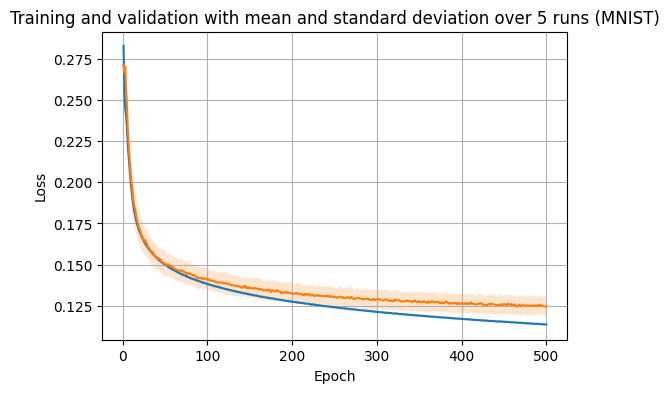

In [13]:
import matplotlib.pyplot as plt
import numpy as np


def plot(metric):
    mean_losses = []
    std_losses = []
    
    for item in tuner.histories:
        hpset = item['hp']
        lr = hpset['lr']
        trials = item['histories']
        losses = np.array([run_history.history[metric] for run_history in trials])
        mean_loss = np.mean(losses, axis=0)
        std_loss = np.std(losses, axis=0)
        mean_losses.append(mean_loss)
        std_losses.append(std_loss)

    epochs = np.arange(1, config.epochs + 1)

    for i, (mean_loss, std_loss) in enumerate(zip(mean_losses, std_losses)):
        plt.plot(epochs, mean_loss)
        plt.fill_between(epochs, mean_loss - std_loss, mean_loss + std_loss, alpha=0.2)


fig, ax = plt.subplots(figsize=(6, 4))

plot('loss')
plot('val_loss')


plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation with mean and standard deviation '
          f'over {config.executions_per_trial} runs ({config.dataset.upper()})')
plt.grid()
plt.show()
plt.close()

### Visualizing the latent space
The codebase includes the callback class `VisualizationCallback` to periodically visualize 2D latent spaces onto tensorboard. I have saved the final images from the previous run. Lets load them here for visualization.

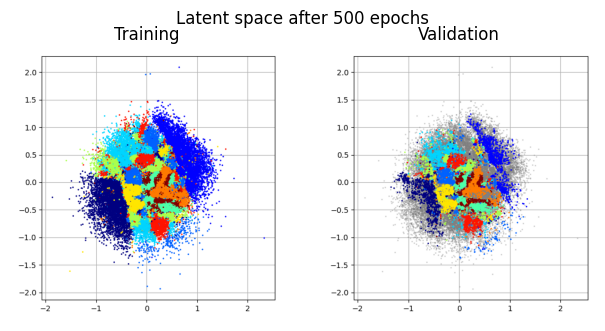

In [35]:
latent_space_train = plt.imread('../examples/mnist/latent_space_train.png')
latent_space_val = plt.imread('../examples/mnist/latent_space_val.png')
plt.subplot(121)
plt.imshow(latent_space_train)
plt.axis('off')
plt.title('Training')
plt.subplot(122)
plt.imshow(latent_space_val)
plt.axis('off')
plt.title('Validation')
plt.suptitle('Latent space after 500 epochs')
plt.tight_layout(rect=[0., .3, 1., 1.])
plt.show()
plt.close()

The colors in the scatter plots above denote samples belonging to different classes. As is clear, the samples belonging to the same class tend to "clump" together, resulting in the clusters we see above. For the validation plot, we overlay the validation set samples in color over the train samples in gray to show that samples from the validation set tend to follow visually similar cluster distribution as in the training samples.

### Conclusion
In this notebook, we are able to learn two dimensional latent spaces from decoder only architectures on the MNIST dataset and show that the learned weights can generalize to validation set.

### Further experiments
This notebook shows a demo. One might want to try out the results with CIFAR and other datasets as well. This approach as of now is not generative, that is, decoder model provides a one-one mapping between points in the latent space to input space. It could be interesting to explore variational approaches in the latent space to make this a decoder only generative model.